DEBUG:cmdstanpy:input tempfile: /tmp/tmpmmumeb4l/pixlr5y5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmmumeb4l/6q48yu24.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63066', 'data', 'file=/tmp/tmpmmumeb4l/pixlr5y5.json', 'init=/tmp/tmpmmumeb4l/6q48yu24.json', 'output', 'file=/tmp/tmpmmumeb4l/prophet_modela33g6fvs/prophet_model-20250109221929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:19:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:20:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 11 forecasts with cutoffs between 2019-07-19 00:00:00 and 2024-06-22 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpmmumeb4l/cewpo2hr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmmumeb4l/nyhmf1y1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47881', 'data', 'file=/tmp/tmpmmumeb4l/cewpo2hr.json', 'init=/tmp/tmpmmumeb4l/nyhmf1y1.json', 'output', 'file=/tmp/tmpmmumeb4l/prophet_model7l5ux9ha/prophet_model-20250109222006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:20:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:20:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmmumeb4l/fm5lu_pc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmmumeb4l/utpyd76h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Cross-validation performance metrics:
          horizon          mse       rmse        mae      mape     mdape  \
0 3 days 01:00:00  1822.345254  42.688936  20.430950  0.018833  0.012705   
1 3 days 02:00:00  1823.166165  42.698550  20.425587  0.018826  0.012705   
2 3 days 03:00:00  1824.252189  42.711265  20.434135  0.018838  0.012701   
3 3 days 04:00:00  1824.168751  42.710289  20.424022  0.018837  0.012705   
4 3 days 05:00:00  1826.996921  42.743385  20.496134  0.018921  0.012778   

      smape  coverage  
0  0.018727  0.887324  
1  0.018721  0.887324  
2  0.018732  0.886044  
3  0.018731  0.886044  
4  0.018816  0.884763  
Validation MAPE: 0.018293996644186943


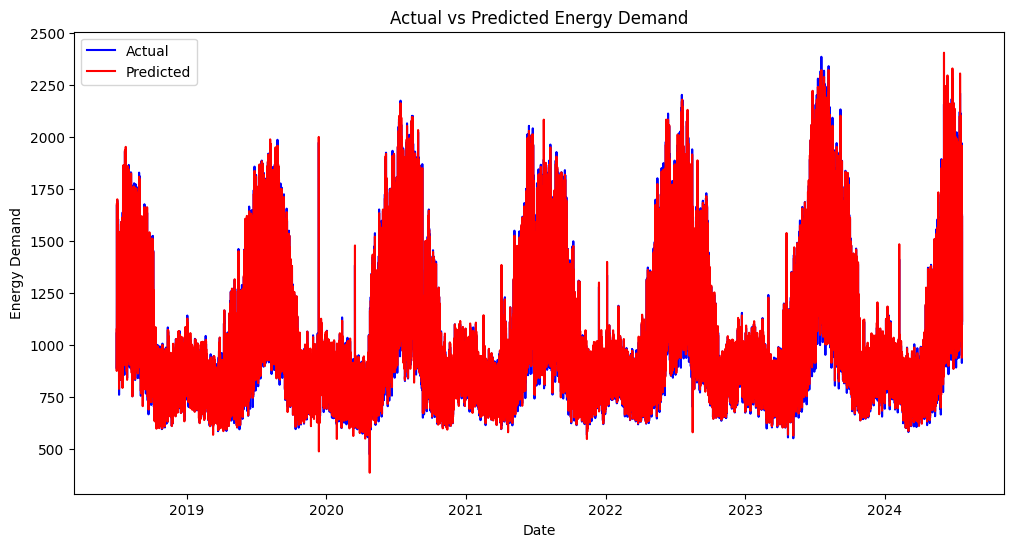

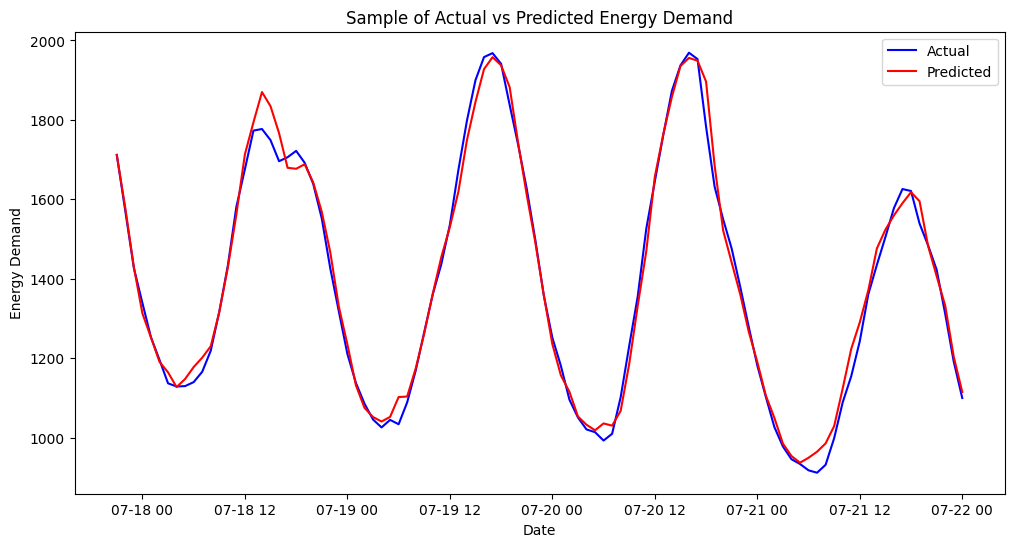

MAPE for data: 1.7780619103021507


In [1]:

import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_excel('/content/ElPasoNew (2).xlsx')
data = data.dropna()
data['Time'] = pd.to_datetime(data['Time'])
df = data.rename(columns={'Time': 'ds', 'D': 'y'})

df['Hour'] = df['ds'].dt.hour
df['DayOfWeek'] = df['ds'].dt.dayofweek
df['Month'] = df['ds'].dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

for lag in range(1, 25):
    df[f'Lag_{lag}'] = df['y'].shift(lag)

df['Temp_RollingMean_24'] = df['Temperature'].rolling(window=24).mean()
df['Temp_RollingStd_24'] = df['Temperature'].rolling(window=24).std()
df['Temp_Humidity_Interaction'] = df['Temperature'] * df['RelativeHumidity']

df.dropna(inplace=True)

model = Prophet()
model.add_regressor('Temperature')
model.add_regressor('DewPoint')
model.add_regressor('WindSpeed')
model.add_regressor('Pressure')
model.add_regressor('RelativeHumidity')
model.add_regressor('Hour')
model.add_regressor('DayOfWeek')
model.add_regressor('Month')
model.add_regressor('IsWeekend')
model.add_regressor('Temp_RollingMean_24')
model.add_regressor('Temp_RollingStd_24')
model.add_regressor('Temp_Humidity_Interaction')

for lag in range(1, 25):
    model.add_regressor(f'Lag_{lag}')

model.fit(df)

df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='30 days')
df_p = performance_metrics(df_cv)
print("Cross-validation performance metrics:")
print(df_p.head())

val_df = df.iloc[-len(df_cv):]
val_df_future = val_df[['ds', 'Temperature', 'DewPoint', 'WindSpeed', 'Pressure', 'RelativeHumidity',
                        'Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'Temp_RollingMean_24',
                        'Temp_RollingStd_24', 'Temp_Humidity_Interaction'] + [f'Lag_{lag}' for lag in range(1, 25)]]

forecast_val = model.predict(val_df_future)
val_mape = mean_absolute_percentage_error(val_df['y'], forecast_val['yhat'])
print("Validation MAPE:", val_mape)

future = df[['ds', 'Temperature', 'DewPoint', 'WindSpeed', 'Pressure', 'RelativeHumidity',
             'Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'Temp_RollingMean_24',
             'Temp_RollingStd_24', 'Temp_Humidity_Interaction'] + [f'Lag_{lag}' for lag in range(1, 25)]]

forecast = model.predict(future)

df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)
aligned_df = df.join(forecast[['yhat']], how='inner')

if len(aligned_df['y']) != len(aligned_df['yhat']):
    print(f"Length mismatch: Actual = {len(aligned_df['y'])}, Predicted = {len(aligned_df['yhat'])}")

plt.figure(figsize=(12, 6))
plt.plot(aligned_df.index, aligned_df['y'], label='Actual', color='b')
plt.plot(aligned_df.index, aligned_df['yhat'], label='Predicted', color='r')
plt.title('Actual vs Predicted Energy Demand')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.show()

sample_period = 100
plt.figure(figsize=(12, 6))
plt.plot(aligned_df.index[-sample_period:], aligned_df['y'].iloc[-sample_period:], label='Actual', color='b')
plt.plot(aligned_df.index[-sample_period:], aligned_df['yhat'].iloc[-sample_period:], label='Predicted', color='r')
plt.title('Sample of Actual vs Predicted Energy Demand')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.show()

non_zero_data = aligned_df[aligned_df['y'] != 0]
non_zero_errors = np.abs((non_zero_data['y'] - non_zero_data['yhat']) / non_zero_data['y'])
non_zero_mape = non_zero_errors.mean() * 100
print("MAPE for data:", non_zero_mape)